In [1]:
# Device specifications
!nvidia-smi

Sun May 29 23:24:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -q install transformers

     |████████████████████████████████| 4.2 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 6.6 MB 72.7 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 


In [3]:
!pip install -qq transformers
!pip install -qq cleanlab
!pip install -qq snorkel

     |████████████████████████████████| 95 kB 2.9 MB/s 
     |████████████████████████████████| 103 kB 4.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 5.6 MB 52.1 MB/s 
     |████████████████████████████████| 14.8 MB 58.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.0+zzzcolab20220506162203 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.0+zzzcolab20220506162203 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.6.0 which is inc

In [4]:
import tensorflow, keras, transformers, cleanlab, snorkel
print(f"tf version: {tensorflow.__version__}")
print(f"keras version: {keras.__version__}")
print(f"transformers version: {transformers.__version__}")
print(f"cleanlab version: {cleanlab.__version__}")
print(f"snorkel version: {snorkel.__version__}")

tf version: 2.8.0
keras version: 2.8.0
transformers version: 4.19.2
cleanlab version: 2.0.0
snorkel version: 0.9.8


# Dependencies

In [6]:
import glob
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")

# Download data

In [7]:
# I will use only one third of the dataset to make the experimentation faster
!wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
# !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
# !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2022-05-29 23:26:21--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  28.2MB/s    in 0.5s    

2022-05-29 23:26:23 (28.2 MB/s) - ‘data/goemotions_1.csv’ saved [14174600/14174600]



# Load data

In [8]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
          'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
          'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
          'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 
          'neutral']
labels_dict = {label:idx for idx, label in enumerate(labels)}

path_list = glob.glob("data/goemotions_*.csv", recursive=True)
dfs = [pd.read_csv(path, usecols=(['text'] + labels)) for path in path_list]
dataset = pd.concat(dfs)
# Shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)

print(f"Number of samples: {len(dataset)}")
print(f"Number of labels: {len(labels)}")
display(dataset.head())

Number of samples: 70000
Number of labels: 28


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,I hate those days man... So triggering,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""Until I lost my penis in a tragic balloon kno...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,All good brother,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3 Hours of [NAME] pissing on the floor in public,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,I like it...but I still wish it was another ne...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Preprocessing

For now, the only preprocessing that we are going to do is lower casing all text and drop samples without text.

We can apply our preprocessing steps to our text feature in the dataframe by wrapping all these processes under a function.

In [9]:
dataset.dropna(subset=["text"], axis=0, inplace=True)
print(f"Number of samples: {len(dataset)}")

Number of samples: 70000


In [10]:
# Define preprocessing function
def preprocess(text, lower=True):
    if lower:
        text = text.lower()
    return text

In [11]:
# Apply to dataframe
dataset.text = dataset.text.apply(preprocess, lower=True)

# Exploratory Data Analysis (EDA)

## Positive labels per text sample

**Question:** How many positive labels do each sample have on average? This might give an idea if samples have too many signals or not (many labels for each sample).

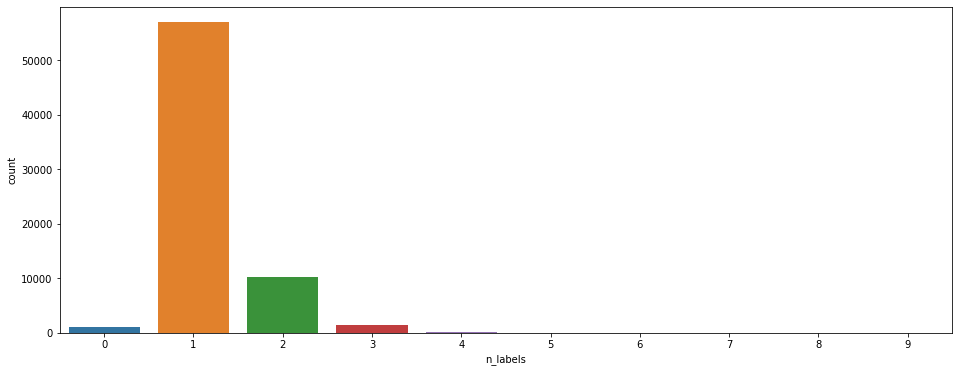

In [12]:
dataset['n_labels'] = dataset[labels].sum(axis=1)

plt.figure(figsize=(16, 6))
sns.countplot(x="n_labels", data=dataset)
plt.show()

## Label distribution

**Question:** How many samples do we have for each label? Which ones are more popular, and which ones might have too few samples?

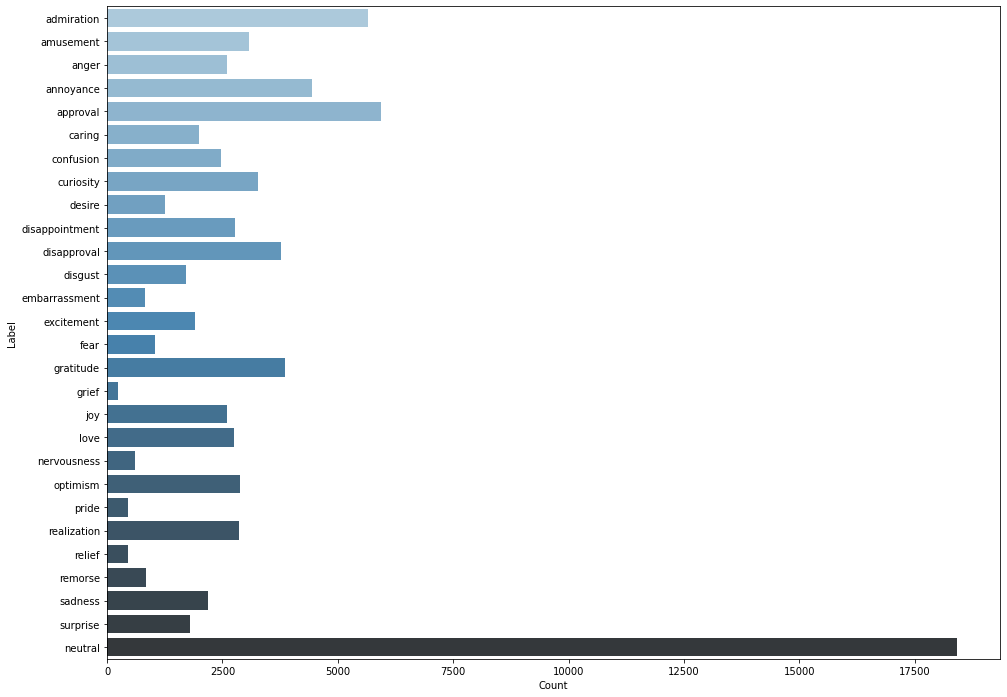

In [13]:
label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']

plt.figure(figsize=(16, 12))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

## Text length

**Question:** How is distributed the size of our text samples? This could give us some insights if some samples might need to be truncated or if some of them are too small to have enough context.

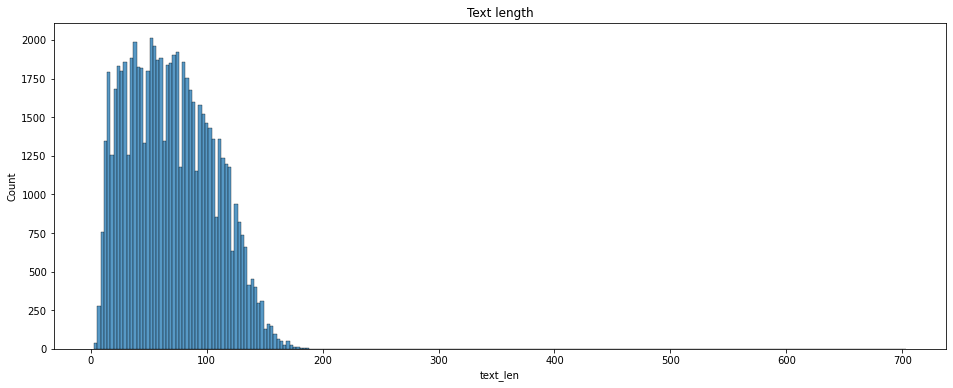

In [14]:
dataset["text_len"] = dataset["text"].apply(lambda x : len(x))

plt.figure(figsize=(16, 6))
sns.histplot(dataset['text_len']).set_title('Text length')
plt.show()

## Wordcloud

**Question:**  Is there enough signal in the text that is related to the label?

### Wordcloud for "gratitude"

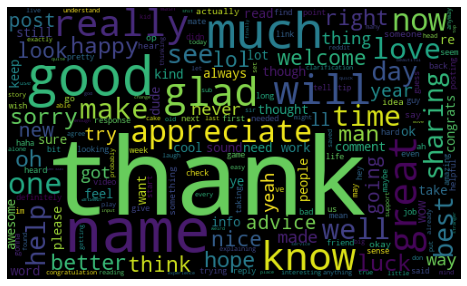

In [15]:
def display_word_cloud(df, label):
    plt.figure(figsize=(15, 5))
    subset = df[df[label] == 1]
    text = subset.text.values
    cloud = WordCloud(stopwords=STOPWORDS, background_color="black", 
                      collocations=False, width=500, 
                      height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

display_word_cloud(dataset, label="gratitude")

### Wordcloud for "sadness"

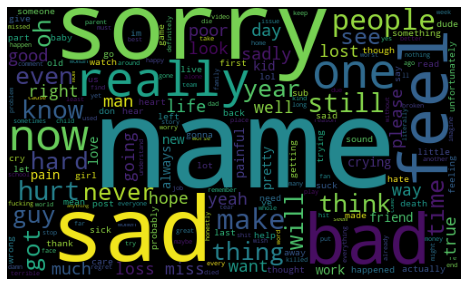

In [16]:
display_word_cloud(dataset, label="sadness")

# Splitting a Dataset for Multilabel Classification


- Train (70%): 147857
- Validation (15%): 31684
- Test (15%): 31684

In [17]:
from sklearn.model_selection import train_test_split
seed = 42

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset[labels], test_size=0.3, random_state=seed)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

In [19]:
train_df = y_train.copy()
train_df["text"] = X_train
print(f"Train samples: {len(train_df)}")

valid_df = y_valid.copy()
valid_df["text"] = X_valid
print(f"Validation samples: {len(valid_df)}")

test_df = y_test.copy()
test_df["text"] = X_test
print(f"Test samples: {len(test_df)}")

Train samples: 49000
Validation samples: 10500
Test samples: 10500


In [20]:
# Save dataset
train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/valid.csv", index=False)
train_df.to_csv("data/test.csv", index=False)

## Data distribution

### Complete dataset

Number of samples: 70000


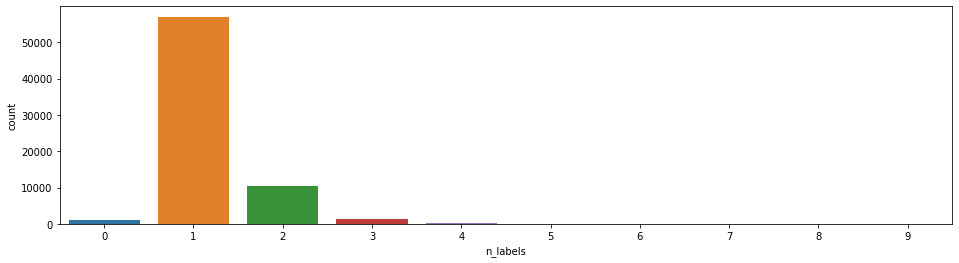

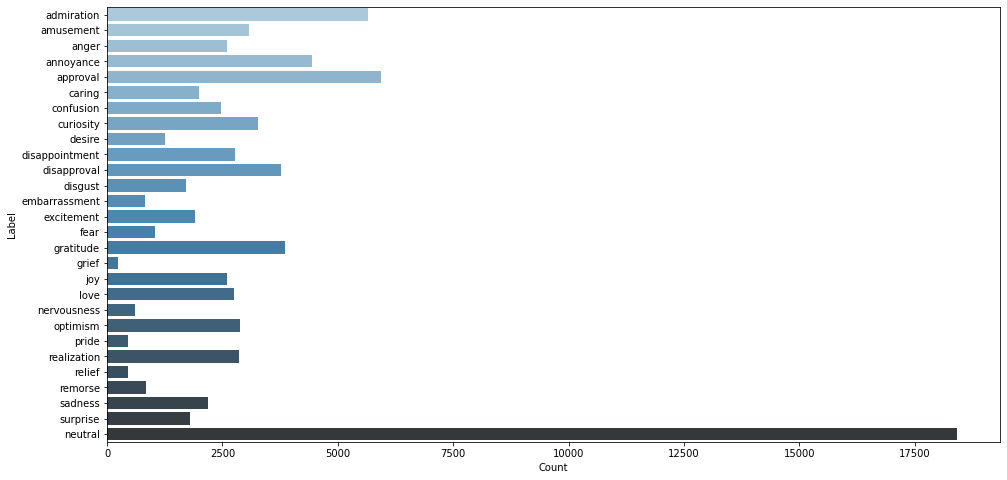

In [21]:
print(f"Number of samples: {len(dataset)}")

dataset['n_labels'] = dataset[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=dataset)
plt.show()

label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

### Train dataset

Number of samples: 49000


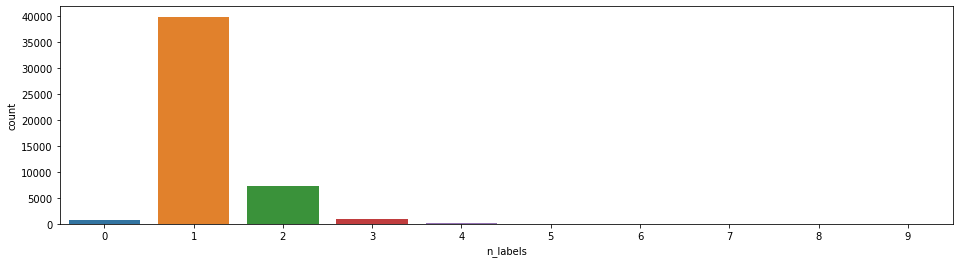

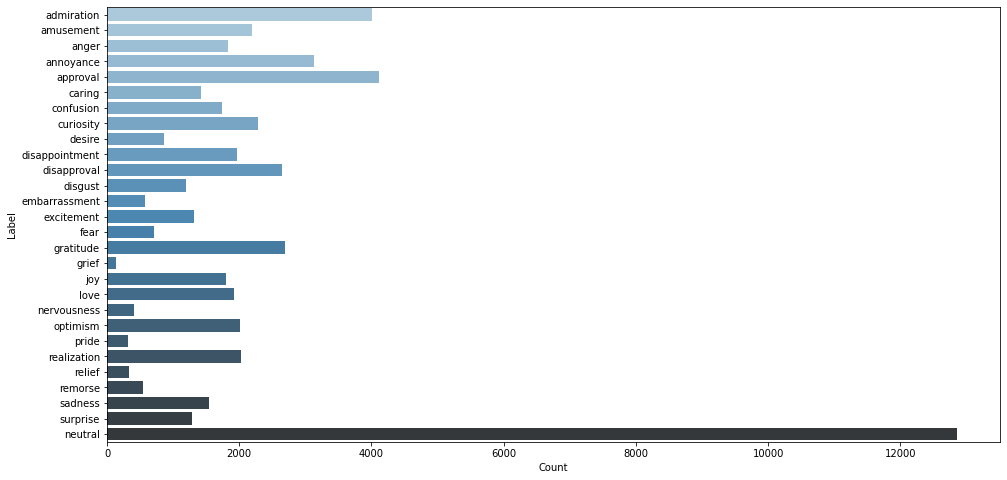

In [22]:
print(f"Number of samples: {len(train_df)}")

train_df['n_labels'] = train_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=train_df)
plt.show()

train_label_count = train_df[labels].agg({x:'sum' for x in labels}).reset_index()
train_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=train_label_count, palette="Blues_d")
plt.show()

### Validation dataset

Number of samples: 10500


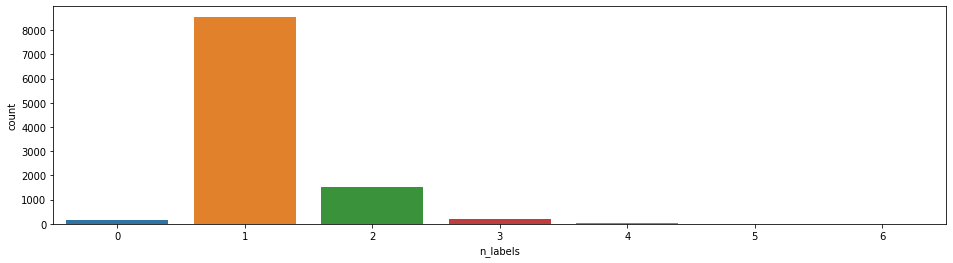

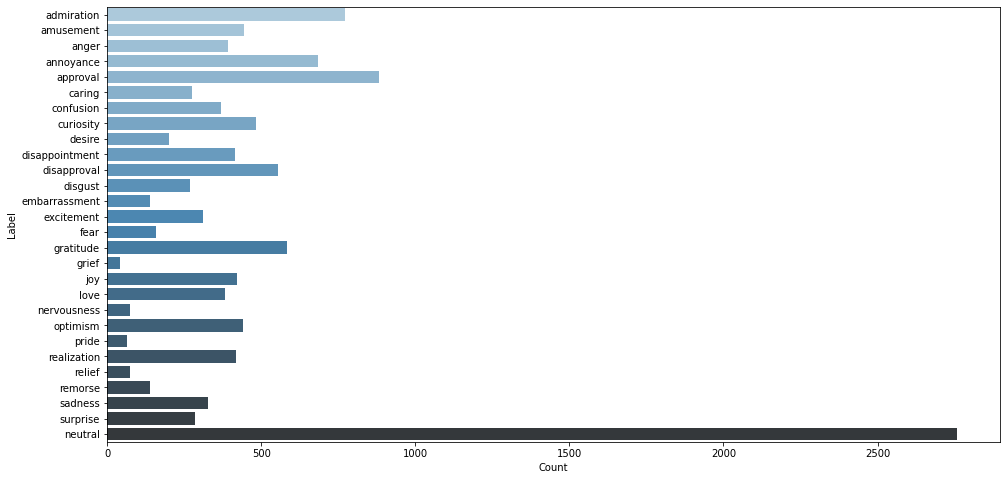

In [23]:
print(f"Number of samples: {len(valid_df)}")

valid_df['n_labels'] = valid_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=valid_df)
plt.show()

valid_label_count = valid_df[labels].agg({x:'sum' for x in labels}).reset_index()
valid_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=valid_label_count, palette="Blues_d")
plt.show()

### Test dataset

Number of samples: 10500


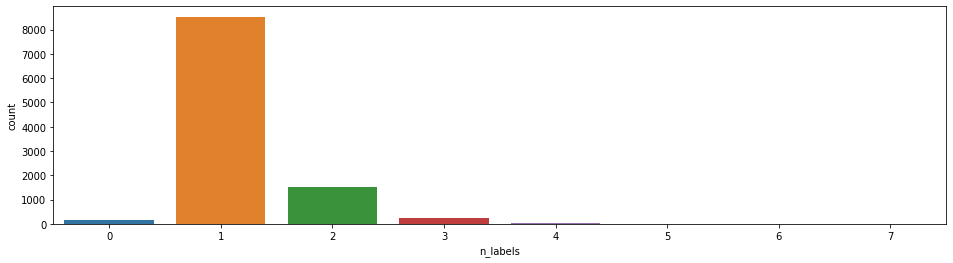

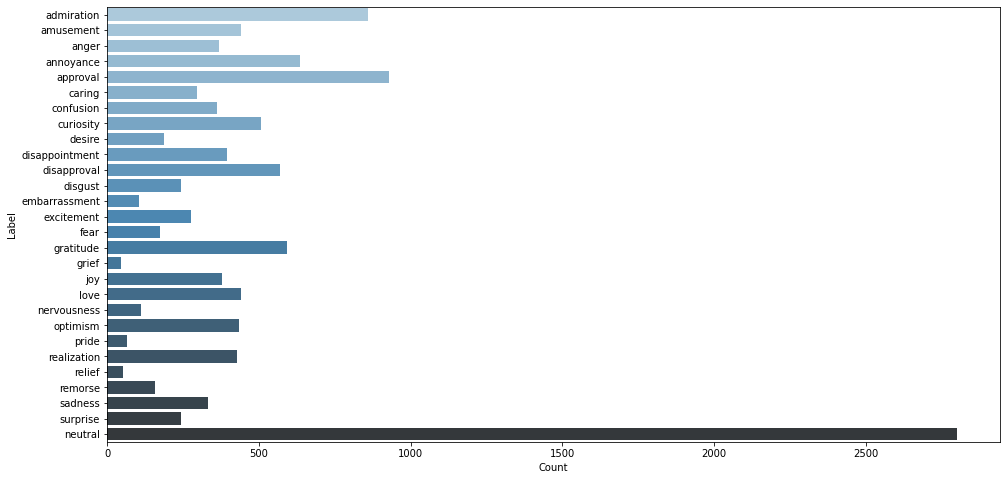

In [24]:
print(f"Number of samples: {len(test_df)}")

test_df['n_labels'] = test_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=test_df)
plt.show()

test_label_count = test_df[labels].agg({x:'sum' for x in labels}).reset_index()
test_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=test_label_count, palette="Blues_d")
plt.show()

# Modeling Baselines

In [25]:
import random, os, json
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Random

motivation: We want to know what random (chance) performance looks like. All of our subsequent baselines should perform better than this.

In [26]:
# Set seeds
set_seeds(seed)

In [27]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(test_df), len(labels)))
print(y_pred.shape)
print(y_pred[:5])

(10500, 28)
[[0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1]
 [0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0]]


### Evaluation

In [28]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.0965521754796707,
  "recall": 0.4975480344079106,
  "f1": 0.14398090148353437
}


We made the assumption that there is an equal probability for whether an input has an emotion or not, but this isn't true. Let's use the train split to figure out what the true probability is.



In [29]:
# Percentage of 1s (tag presence)
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(labels))
print(tag_p)

0.04215816326530612


In [30]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(labels)),
    p=[1-tag_p, tag_p])

In [31]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(labels))

0.04228231292517007

### Evaluation

In [32]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.09680884482945866,
  "recall": 0.0471098962939143,
  "f1": 0.053603076609740063
}


**limitations:** we didn't use any of the signals from our inputs to affect our predictions, so nothing was learned.



## Rule-based

motivation: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

### Top-K words

Usually in texts, emotions are heavily correlated with the occurrences of a few words that gives drives the main emotion of that text, sometimes that words can be the emotions themselves, let's try to predict the labels looking if a piece of text contains words that are commonly found in other texts with the same emotions.

**Domain knowledge**: This dataset has anonymized names, so instead of a person's name we have `[name]` instead, this adds no value to our predictions, so let's also remove this from the top-K words

In [33]:
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop.append("[name]")
stop.append("[name].")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
def get_top_k_words(dataset, k=15, label="love"):
    label_text = dataset[dataset[label] == 1].text
    clean_text = label_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    top_k_words = pd.Series(' '.join(clean_text).split()).value_counts().index[:k]
    return list(top_k_words)

In [35]:
# Top-15 words for "grief"
print(get_top_k_words(train_df, k=15, label="grief"))

['died', 'sorry', 'people', 'one', 'i’m', 'like', "i'm", 'guy', 'looks', 'probably', 'get', 'dead.', 'crying', 'got', 'last']


In [36]:
# Top-15 words for "love"
print(get_top_k_words(train_df, k=15, label="love"))

['love', 'like', 'would', 'it.', 'loved', 'really', 'favorite', 'one', "i'm", 'see', 'people', 'good', 'get', 'loves', 'much']


In [37]:
# Create a dict with top-K words for each label
def get_top_words_dict(dataset, labels=labels, k=15):
    return {label:get_top_k_words(train_df, k=k, label=label) for label in labels}

In [38]:
top_words_dict = get_top_words_dict(train_df)
pprint(top_words_dict)

{'admiration': ['good',
                'like',
                'great',
                'love',
                'one',
                'really',
                'pretty',
                'best',
                "that's",
                'nice',
                "i'm",
                'amazing',
                'looks',
                'would',
                'get'],
 'amusement': ['lol',
               'like',
               'haha',
               'lol.',
               'funny',
               'fun',
               'good',
               'lmao',
               'would',
               "i'm",
               'people',
               'really',
               'love',
               'get',
               'think'],
 'anger': ['fuck',
           'hate',
           'like',
           'fucking',
           'people',
           'get',
           'one',
           'would',
           "i'm",
           'hell',
           'really',
           'know',
           'stop',
           'even',
          

Some words are too common and appear in many different labels, let's remove those words that appear in at least 20% of the total labels.

In [39]:
from collections import Counter

label_words = []
for words in top_words_dict.values():
    label_words.extend(words)

label_counts = Counter(label_words)
print(label_counts)

Counter({'like': 28, "i'm": 28, 'get': 26, 'really': 24, 'would': 23, 'one': 19, 'people': 19, 'i’m': 14, 'good': 12, "that's": 12, 'think': 12, 'know': 12, 'even': 12, 'love': 9, 'still': 9, 'see': 8, 'got': 7, 'feel': 7, 'oh': 6, 'bad': 5, 'never': 5, 'don’t': 4, 'hope': 4, 'make': 4, 'sorry': 4, 'glad': 4, 'it.': 3, 'you.': 3, 'it’s': 3, 'great': 2, 'looks': 2, 'fun': 2, 'fuck': 2, 'hate': 2, 'fucking': 2, 'need': 2, 'go': 2, 'wish': 2, 'weird': 2, 'happy': 2, 'thank': 2, ':)': 2, 'much': 2, 'better': 2, 'pretty': 1, 'best': 1, 'nice': 1, 'amazing': 1, 'lol': 1, 'haha': 1, 'lol.': 1, 'funny': 1, 'lmao': 1, 'hell': 1, 'stop': 1, 'damn': 1, 'keep': 1, 'take': 1, 'sure': 1, 'maybe': 1, 'curious': 1, 'want': 1, 'could': 1, 'wanted': 1, "can't": 1, 'worst': 1, 'disgusting.': 1, 'worse': 1, 'shame': 1, 'excited': 1, 'new': 1, 'scared': 1, 'afraid': 1, 'terrible': 1, 'scary': 1, 'fear': 1, 'thanks': 1, 'thanks!': 1, 'you!': 1, 'thanks.': 1, 'appreciate': 1, 'died': 1, 'guy': 1, 'probably':

In [40]:
words_to_remove = []
for word, cnt in label_counts.items():
    if cnt >= (len(labels) * 0.4):
      words_to_remove.append(word)
print(words_to_remove)

['good', 'like', 'one', 'really', "that's", "i'm", 'would', 'get', 'people', 'think', 'know', 'even', 'i’m']


In [41]:
for key, value in top_words_dict.items():
    top_words_dict[key] = [word for word in value if word not in words_to_remove]
pprint(top_words_dict)

{'admiration': ['great', 'love', 'pretty', 'best', 'nice', 'amazing', 'looks'],
 'amusement': ['lol', 'haha', 'lol.', 'funny', 'fun', 'lmao', 'love'],
 'anger': ['fuck', 'hate', 'fucking', 'hell', 'stop', 'damn'],
 'annoyance': ['fucking', 'fuck', 'don’t', 'still'],
 'approval': ['see', 'love', 'it.', 'got'],
 'caring': ['feel',
            'hope',
            'love',
            'keep',
            'you.',
            'need',
            'take',
            'go',
            'don’t'],
 'confusion': ['sure', 'don’t', 'still', 'maybe'],
 'curiosity': ['see', 'curious', 'love', 'oh'],
 'desire': ['wish',
            'want',
            'hope',
            'could',
            'see',
            'need',
            'make',
            'love',
            'wanted'],
 'disappointment': ['bad', 'never', 'feel', 'still', 'it’s', 'got'],
 'disapproval': ['don’t', "can't", 'bad', 'never'],
 'disgust': ['weird', 'bad', 'worst', 'hate', 'disgusting.', 'worse'],
 'embarrassment': ['bad', 'shame', 

In [42]:
# Prediction
def predict_top_k(input, labels=labels, labels_dict=top_words_dict):
    y_pred = []
    for text in input:
        preds = []
        for label in labels:
            if any(word in text.split() for word in labels_dict[label]):
                preds.append(1)
            else:
                preds.append(0)
        y_pred.append(preds)
    return y_pred

y_pred = predict_top_k(X_test)

### Evaluation

In [43]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.18055684566839975,
  "recall": 0.2488946056756974,
  "f1": 0.17943667474315564
}


### Inference

In [44]:
def inference_top_k(input, labels=labels, labels_dict=top_words_dict):
    preds = {}
    for label in labels:
        if any(word in input.split() for word in labels_dict[label]):
            preds[label] = 1
        else:
            preds[label] = 0
    return preds

text = "I am loving this amazing MLOps tutorial, so much cool content"
pprint(inference_top_k(text))

{'admiration': 1,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 1,
 'grief': 0,
 'joy': 0,
 'love': 1,
 'nervousness': 0,
 'neutral': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 0,
 'surprise': 0}


**limitations:** we failed to generalize or learn any implicit patterns to predict the labels because we are trying to predict by using the words themselves, and we do not capture text context or intention, where most of the emotion would be captured.

> We could further improve this approach by using more preprocessing like removing punctuation or using top-k words that are more unique for each label, applying maybe normalization similar to TF-IDF.

## Simple ML

**motivation:**
- **representation:** use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.
- **architecture:** we want our model to meaningfully extract the encoded signal to predict the output labels.

So far, we've treated the words in our input text as isolated tokens, and we haven't really captured any meaning between tokens. Let's use term frequency–inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [46]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [47]:
# Tf-idf
vectorizer = TfidfVectorizer()
print(X_train.iloc[0])
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_train_tfidf[0]) # scipy.sparse.csr_matrix

someone get fat boy [name] a happy meal.
(49000, 23882)
  (0, 13118)	0.5292026835081637
  (0, 9801)	0.33498431416774205
  (0, 13945)	0.18373137499837075
  (0, 2946)	0.4224880039037505
  (0, 7960)	0.47549392155685
  (0, 9094)	0.2592408885819284
  (0, 19582)	0.319650417921984


In [48]:
def fit_and_evaluate(model):
    """Fit and evaluate each model."""
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [49]:
  # Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))

performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))

print(json.dumps(performance, indent=2))

{
  "logistic-regression": {
    "precision": 0.5680240565904389,
    "recall": 0.1150414020419648,
    "f1": 0.170343974960257
  },
  "support-vector-machine": {
    "precision": 0.45008617202143403,
    "recall": 0.19495136264973068,
    "f1": 0.2583025251191575
  }
}


**limitations:**

- **representation:** TF-IDF representations don't encapsulate much signal beyond frequency, but we require more fine-grained token representations.
- **architecture:** we want to develop models that can use better represented encodings in a more contextual manner

## CNN w/ Embeddings

**motivation:**

- **representation**: we want to have more robust (split tokens to characters) and meaningful embedding-based representations for our input tokens.
- **architecture**: we want to process our encoded inputs using convolution (CNN) filters that can learn to analyze windows of embedded tokens to extract meaningful signal.

### Set up

In [50]:
import tensorflow.keras.layers as L

# Looking at the "EDA" part, 128 length should cover most samples.
max_seq_len = 128

### Tokenizer

We're going to tokenize our input text as character tokens, so we can be robust to spelling errors and learn to generalize across words.

In [51]:
# Define split strategy
@tf.keras.utils.register_keras_serializable()
def cnn_split(text):
  return tf.strings.unicode_split(text, 'UTF-8')

# Define standardization strategy
@tf.keras.utils.register_keras_serializable()
def cnn_standardization(text):
    lowercased = tf.strings.lower(text)
    return lowercased

# Create a TextVectorization layer
text_vectorizer = L.TextVectorization(
    standardize=cnn_standardization, 
    split=cnn_split, 
    output_mode="int",
    output_sequence_length=max_seq_len
)

In [52]:
# Tokenize
text_vectorizer.adapt(X_train.values)

vocab = text_vectorizer.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(vocab)

Vocabulary size: 499
['', '[UNK]', ' ', 'e', 't', 'o', 'a', 'i', 'n', 's', 'h', 'r', 'l', 'd', 'u', 'm', 'y', 'g', 'c', 'w', '.', 'f', 'p', 'b', 'k', 'v', "'", ',', '!', '[', ']', '’', 'j', '?', 'x', '"', '0', 'z', '-', '*', '1', ':', '2', 'q', '/', ')', '(', '3', '5', '>', '4', '“', '”', '9', '6', '8', '⠀', '7', '^', '|', '~', '😂', ';', '%', '$', '#', '+', '️', '_', '😤', '=', '⣿', '<', '&', '🤣', '‘', '❤', '😭', '👏', '🦀', '⠛', '\u200d', '@', '😎', '🤔', '⣤', '⣀', '🏻', '👍', '—', '⠶', '🙏', '😍', '¯', '🤷', '😡', '😉', '🔥', '🏼', '👌', '🙄', '😊', '💜', '♥', '♀', '£', '⢀', '😩', '😢', '⠉', '☺', '♂', '😅', '⣶', 'é', '⠋', '⠃', '⠁', '😏', '👀', '🌈', '☹', '™', '🤗', '😁', 'ツ', '⣄', '⡟', '💯', '🙌', '🏳', '🎶', '⢠', '⡀', '€', '}', '🤦', '😬', '😘', '😄', '💖', '💕', '🎉', '🤬', '🤢', '😐', '💀', '🇺', '🇸', '⣾', '⣼', '⣷', 'ᴛ', 'ᴏ', 'ɪ', '🤮', '🙃', '😔', '😒', '😆', '\\', '🤲', '🔪', '🎵', '🅱', '⣇', '⢿', '⢹', '⢰', '⢤', '⡿', '⡄', '⠿', '⠦', '⠙', '⠘', '⠇', '✔', 'ᴀ', '̻', 'á', '°', '`', '🤩', '🤙', '😥', '😞', '😇', '💓', '💅', '🏽', '…', '„', '͝',

In [53]:
print ("Text to indices:\n"
    f"(preprocessed) → {X_train.iloc[0]}\n"
    f"(tokenized) → {text_vectorizer(X_train.iloc[0]).numpy()}")

Text to indices:
(preprocessed) → someone get fat boy [name] a happy meal.
(tokenized) → [ 9  5 15  3  5  8  3  2 17  3  4  2 21  6  4  2 23  5 16  2 29  8  6 15
  3 30  2  6  2 10  6 22 22 16  2 15  3  6 12 20  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


### Data imbalance

We'll factor class weights in our objective function ([binary cross entropy with logits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)) to help with [class imbalance](https://madewithml.com/courses/mlops/labeling/#data-imbalance). There are many other techniques such as over sampling from underrepresented classes, undersampling, etc. but we'll cover these in a separate unit lesson on data imbalance

In [54]:
# Class weights
counts = [len(train_df[train_df[label] == 1]) for label in labels]
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [4015, 2196, 1828, 3124, 4118, 1417, 1737, 2276, 861, 1962, 2647, 1193, 572, 1313, 713, 2686, 140, 1804, 1919, 412, 2010, 320, 2022, 327, 551, 1536, 1279, 12863],
class weights: {0: 0.00024906600249066, 1: 0.0004553734061930783, 2: 0.0005470459518599562, 3: 0.0003201024327784891, 4: 0.00024283632831471587, 5: 0.0007057163020465773, 6: 0.0005757052389176742, 7: 0.0004393673110720562, 8: 0.0011614401858304297, 9: 0.0005096839959225281, 10: 0.00037778617302606723, 11: 0.0008382229673093043, 12: 0.0017482517482517483, 13: 0.0007616146230007616, 14: 0.001402524544179523, 15: 0.00037230081906180194, 16: 0.007142857142857143, 17: 0.0005543237250554324, 18: 0.0005211047420531526, 19: 0.0024271844660194173, 20: 0.0004975124378109452, 21: 0.003125, 22: 0.0004945598417408506, 23: 0.0030581039755351682, 24: 0.0018148820326678765, 25: 0.0006510416666666666, 26: 0.0007818608287724785, 27: 7.774236181295187e-05}


### Datasets

Here we are going to use [TF.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to efficiently load and process data for training, evaluation, and inference.

In [55]:
def get_dataset(x, y, labels=labels, labeled=True, ordered=False, 
                repeated=True, batch_size=64):
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(x)
  
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [56]:
# Create datasets
cnn_train_dataset = get_dataset(train_df.text, train_df[labels])
cnn_valid_dataset = get_dataset(valid_df.text, valid_df[labels], ordered=True, repeated=False)
cnn_test_dataset = get_dataset(test_df.text, test_df[labels], ordered=True, repeated=False)

for sample in cnn_train_dataset.take(1):
    x = sample[0]
    y = sample[1]
    print("Sample point:\n"
    f"  X: {x[0].numpy().decode()}\n"
    f"  y: {y[0].numpy()}"
    )
    print("Sample shape:\n"
    f"  X: {x.shape}\n"
    f"  y: {y.shape}"
    )

Sample point:
  X: what does an endorsement really do though? does it seem like a publicity stunt?
  y: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample shape:
  X: (64,)
  y: (64, 28)


### Model

We'll be using a convolutional neural network on top of our embedded tokens to extract meaningful spatial signal. This time, we'll be using many filter widths to act as n-gram feature extractors.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_1.gif?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (batch_size, max_seq_len).
2. Then we'll embed our tokenized inputs (batch_size, max_seq_len, embedding_dim).
3. We'll apply convolution via filters (filter_size, embedding_dim, num_filters) followed by batch normalization. Our filters act as character level n-gram detectors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectively.
4. We'll apply 1D global max pooling, which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_2.png?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model

In [57]:
# Arguments
embedding_dim = 128
num_filters = 128
hidden_dim = 128
dropout_p = 0.5
filter_sizes = [2, 3, 4]

In [58]:
def model_fn(tokenizer, num_classes, embedding_dim, filter_sizes, 
                 num_filters, hidden_dim, dropout_p):
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    token_x = tokenizer(inputs)

    emb_x = L.Embedding(input_dim=len(tokenizer.get_vocabulary()),
                        output_dim=embedding_dim)(token_x)

    convs = [L.Conv1D(filters=num_filters, 
                      kernel_size=f, 
                      activation='relu', 
                      padding='same') for f in filter_sizes]
    b_norms = [L.BatchNormalization() for _ in filter_sizes]
    max_pooling = L.MaxPool1D(num_filters)

    x_conv = []
    for i, f in enumerate(filter_sizes):
        # Conv
        _x_conv = convs[i](emb_x)

        # Batch norm
        _x_conv = b_norms[i](_x_conv)

        # Pool
        _x_conv = max_pooling(_x_conv)
        _x_conv = tf.squeeze(_x_conv, axis=1)
        x_conv.append(_x_conv)

    x_concat = tf.concat(x_conv, axis=-1)
    fc_x = L.Dropout(dropout_p)(x_concat)
    fc_x = L.Dense(hidden_dim)(fc_x)
    outputs = L.Dense(num_classes, activation='sigmoid')(fc_x)

    model = tf.keras.Model(inputs, outputs)
    return model

- **VALID**: no padding, the filters only use the "valid" values in the input. If the filter cannot reach all the input values (filters go left to right), the extra values on the right are dropped.
- **SAME**: adds padding evenly to the right (preferred) and left sides of the input so that all values in the input are processed.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_3.png?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model


We're usin SAME padding so that the convolutional outputs are the same shape as our inputs. The amount of padding for the SAME padding can be determined using the same equation. We want our output to have the same width as our input, so we solve for P:

 
If  is not a whole number, we round up (using math.ceil) and place the extra padding on the right side.

As you can see we are using the **tokenizer as part of our model graph**, this has many advantages, specially considering deployment and serving, with this setup we don't have two moving pieces (model and tokenizer), here they are fused as one, thus we only care to train, store, deploy and monitor a single piece. Another advantage is that this way we can **feed the mode raw strings** instead of tokenized inputs.

In [59]:
# Initialize model
cnn_model = model_fn(text_vectorizer, len(labels), embedding_dim, filter_sizes, 
                     num_filters, hidden_dim, dropout_p)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     63872       ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 128, 128)     32896       ['embedding[0][0]']          

### Training

In [60]:
def get_strategy():
    # TPU or GPU detection
    # Detect hardware, return appropriate distribution strategy
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print(f'Running on TPU {tpu.master()}')
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()
    return strategy

In [61]:
strategy = get_strategy()

In [62]:
# Arguments
lr = 2e-4
num_epochs = 15
steps_per_epoch = 500
patience = 3

In [63]:
# Define loss & metrics
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics_fn = tf.keras.metrics.BinaryAccuracy()

In [64]:
# Define optimizer & scheduler
optimizer = tf.keras.optimizers.Adam(lr=lr)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 mode='min', factor=0.1, 
                                                 patience=patience, verbose=1)

In [65]:
# Compile model
cnn_model.compile(optimizer=optimizer, 
                  loss=loss_fn, 
                  metrics=metrics_fn)

In [66]:
# Train
with strategy.scope():
    cnn_model.fit(x=cnn_train_dataset, 
                  validation_data=cnn_valid_dataset, 
                  steps_per_epoch=steps_per_epoch, 
                  callbacks=[scheduler], 
                  epochs=num_epochs, 
                  class_weight=class_weights, 
                  verbose=2)

Epoch 1/15
500/500 - 20s - loss: 1.0646e-04 - binary_accuracy: 0.9426 - val_loss: 0.2873 - val_binary_accuracy: 0.9579 - lr: 2.0000e-04 - 20s/epoch - 39ms/step
Epoch 2/15
500/500 - 7s - loss: 7.8505e-05 - binary_accuracy: 0.9577 - val_loss: 0.1647 - val_binary_accuracy: 0.9580 - lr: 2.0000e-04 - 7s/epoch - 13ms/step
Epoch 3/15
500/500 - 7s - loss: 7.4997e-05 - binary_accuracy: 0.9582 - val_loss: 0.1596 - val_binary_accuracy: 0.9587 - lr: 2.0000e-04 - 7s/epoch - 13ms/step
Epoch 4/15
500/500 - 6s - loss: 7.2860e-05 - binary_accuracy: 0.9586 - val_loss: 0.1559 - val_binary_accuracy: 0.9593 - lr: 2.0000e-04 - 6s/epoch - 13ms/step
Epoch 5/15
500/500 - 6s - loss: 7.1775e-05 - binary_accuracy: 0.9585 - val_loss: 0.1546 - val_binary_accuracy: 0.9593 - lr: 2.0000e-04 - 6s/epoch - 13ms/step
Epoch 6/15
500/500 - 7s - loss: 7.0579e-05 - binary_accuracy: 0.9586 - val_loss: 0.1535 - val_binary_accuracy: 0.9593 - lr: 2.0000e-04 - 7s/epoch - 13ms/step
Epoch 7/15
500/500 - 7s - loss: 6.9351e-05 - binar

### Evaluation

In [67]:
import pickle
from pathlib import Path
from sklearn.metrics import precision_recall_curve

In [68]:
y_true = np.array([y.numpy() for x, y in iter(cnn_valid_dataset.unbatch())])
cnn_train_x = cnn_valid_dataset.map(lambda x, y: x)
y_prob = cnn_model.predict(cnn_train_x)

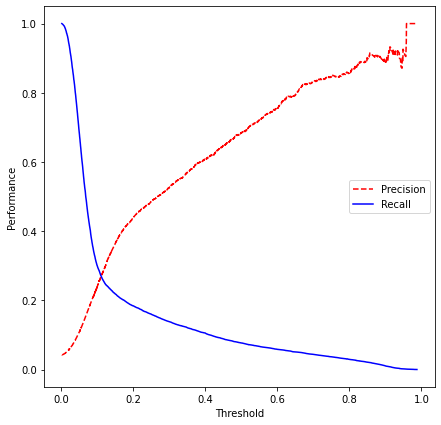

In [69]:
# Threshold-PR curve
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())

plt.figure(figsize=(7, 7))
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.show()

In [70]:
# Determining the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [71]:
# Best threshold for f1
cnn_threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
print(cnn_threshold)

0.13485715


**How can we do better?**


How can we improve on our process of identifying and using the appropriate threshold?


<details><summary><b> Show answer </b></summary>
<p>

- Plot PR curves for all classes (not just overall) to ensure a certain global threshold doesn't deliver very poor performance for any particular class
- Determine different thresholds for different classes and use them during inference

</p>
</details>

In [72]:
y_true = np.array([y.numpy() for x, y in iter(cnn_test_dataset.unbatch())])
cnn_test_x = cnn_test_dataset.map(lambda x, y: x)
y_prob = cnn_model.predict(cnn_test_x)

# Determine predictions using threshold
y_pred = np.array([np.where(prob >= cnn_threshold, 1, 0) for prob in y_prob])

In [73]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.37255784486171706,
  "recall": 0.23780046627542406,
  "f1": 0.2249779940325311
}


In [74]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)

# Pickle the tokenizer's config and weights
pickle.dump({'config': text_vectorizer.get_config(),
             'weights': text_vectorizer.get_weights()}, 
             open(f"{dir}/tokenizer.pkl", "wb"))

# Saving model with the SavedModel format
cnn_model.save(f"{dir}/cnn_model", save_format="tf")

# Saving performance metrics
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

INFO:tensorflow:Assets written to: cnn/cnn_model/assets


### Inference

In [75]:
# Load artifacts
from_disk = pickle.load(open(f"{dir}/tokenizer.pkl", "rb"))
tokenizer = L.TextVectorization.from_config(from_disk['config'])

# This might not work for some TF versions
# loaded_cnn_model = tf.keras.models.load_model(f"{dir}/cnn_model")
loaded_cnn_model = cnn_model
loaded_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     63872       ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 128, 128)     32896       ['embedding[0][0]']          

In [76]:
# Dataloader
text = ["I am loving this amazing MLOps tutorial, so much cool content"]
x_text = get_dataset(text, _, ordered=True, repeated=False, labeled=False)

In [77]:
def decode_preds(preds, labels=labels):
  outputs = []
  for pred in preds:
    decoded = [labels[i] for i, v in enumerate(pred) if v == 1]
    outputs.append(decoded)
  return outputs

In [78]:
y_prob = loaded_cnn_model.predict(x_text)
y_pred = np.array([np.where(prob >= cnn_threshold, 1, 0) for prob in y_prob])
print(decode_preds(y_pred))

[['admiration', 'excitement', 'love']]


**limitations:**

- **representation:** embeddings are not contextual.
- **architecture:** extracting signal from encoded inputs is limited by filter widths.

> Since we're dealing with simple architectures and fast training times, it's a good opportunity to explore tuning and experiment with k-fold cross validation to properly reach any conclusions about performance.

## Transformers w/ Transfer learning

**motivation:**

- **representation**: now with transformers we have contextual embeddings, and the whole sentence can contribute to the meaning of each word.
- **architecture**: we want to process our encoded inputs using transformers layers and a positional encoder, this setup allows us to feed the complete sentence together as context, instead of as a sequence like we did with the CNN.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/transformer_model.png?raw=true)
> Image source: https://jalammar.github.io/illustrated-transformer/

If you want to know more about transformers and how they work, here are a couple of good sources:
 - [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
 - [How Transformers work in deep learning and NLP: an intuitive introduction](https://theaisummer.com/transformer/)

### Set up

In [79]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification

### Tokenizer

With transformers, we will tokenize the inputs not as single characters, as we did previously, now we will tokenize them as sub-words, this is a common approach for transformers and give many advantages.

In [80]:
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

In [81]:
vocab = tokenizer.get_vocab()
print(f"Vocabulary size: {len(vocab)}")
print(list(vocab.items())[:10])

Vocabulary size: 50265
[('LAB', 44435), ('98', 5208), ('ĠKl', 7507), ('Ġcanv', 26550), ('ĠDEL', 16286), ('Ġstartling', 26556), ('KEY', 33754), ('ĠAMA', 33614), ('ĠMarriage', 29795), ('Ġloans', 2973)]


In [82]:
print ("Text to indices:\n"
      f"(preprocessed) → {X_train.iloc[0]}\n"
      f"(tokenized) → {tokenizer(X_train.iloc[0]).input_ids}")

Text to indices:
(preprocessed) → someone get fat boy [name] a happy meal.
(tokenized) → [0, 40100, 120, 5886, 2143, 646, 13650, 742, 10, 1372, 5820, 4, 2]


### Datasets

Here we are going to use [TF.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to efficiently load and process data for training, evaluation, and inference.

In [83]:
def get_dataset_hf(x, y, tokenizer, max_seq_len=max_seq_len, labels=labels, 
                   labeled=True, ordered=False, repeated=True, batch_size=64):
    token_x = tokenizer(x, max_length=max_seq_len, truncation=True, 
                        padding='max_length', return_tensors='tf')

    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input_ids': token_x['input_ids'], 
              'attention_mask': token_x['attention_mask']}, (y)
            )
        )
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            {'input_ids': token_x['input_ids'], 
             'attention_mask': token_x['attention_mask']}
        )
  
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [84]:
# Create datasets
transformer_train_dataset = get_dataset_hf(list(train_df.text), train_df[labels], tokenizer)
transformer_valid_dataset = get_dataset_hf(list(valid_df.text), valid_df[labels], tokenizer, 
                                           ordered=True, repeated=False)
transformer_test_dataset = get_dataset_hf(list(test_df.text), test_df[labels], tokenizer, 
                                          ordered=True, repeated=False)

for sample in transformer_train_dataset.take(1):
    x = sample[0]
    y = sample[1]
    print("Sample point:\n"
    f"  X: {x['input_ids'][0].numpy()}\n"
    f"  y: {y[0]}"
    )
    print("Sample shape:\n"
    f"  X: {x['input_ids'][0].numpy().shape}\n"
    f"  y: {y.shape}"
    )

Sample point:
  X: [    0 12196     5  3031 26536     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
  y: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample shape:
  X: (128,)
  y: (64, 28)


### Model

In [85]:
transformer_model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")
transformer_model.layers[0].trainable = False
transformer_model.summary()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 612124    
 ficationHead)                                                   
                                                                 
Total params: 124,667,164
Trainable params: 612,124
Non-trainable params: 124,055,040
_________________________________________________________________


### Train

In [86]:
# Arguments
lr = 3e-5
num_epochs = 1 #5
steps_per_epoch = 100
patience = 3

In [87]:
# Define loss & metrics
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics_fn = tf.keras.metrics.BinaryAccuracy()

In [88]:
# Define optimizer & scheduler
optimizer = tf.keras.optimizers.Adam(lr=lr)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 mode='min', factor=0.1, 
                                                 patience=patience, verbose=1)

In [89]:
# Compile model
transformer_model.compile(optimizer=optimizer, 
                          loss=loss_fn, 
                          metrics=metrics_fn)

In [90]:
# Train
with strategy.scope():
    transformer_model.fit(x=transformer_train_dataset, 
                          validation_data=transformer_valid_dataset, 
                          steps_per_epoch=steps_per_epoch, 
                          callbacks=[scheduler], 
                          epochs=num_epochs, 
                          class_weight=class_weights, 
                          verbose=2)

100/100 - 102s - loss: 3.3442e-04 - binary_accuracy: 0.7986 - val_loss: 0.6636 - val_binary_accuracy: 0.8179 - lr: 3.0000e-05 - 102s/epoch - 1s/step


### Evaluation

In [91]:
y_true = np.array([y.numpy() for x, y in iter(transformer_valid_dataset.unbatch())])
transformer_train_x = transformer_valid_dataset.map(lambda x, y: x)
y_prob = transformer_model.predict(transformer_train_x)['logits']

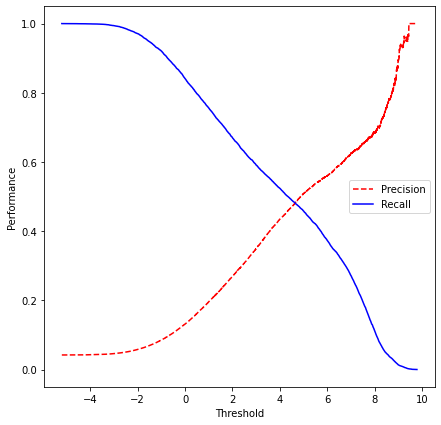

In [92]:
# Threshold-PR curve
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())

plt.figure(figsize=(7, 7))
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.show()

In [93]:
# Best threshold for f1
transformer_threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
print(transformer_threshold)

4.778801


In [94]:
y_true = np.array([y.numpy() for x, y in iter(transformer_test_dataset.unbatch())])
transformer_test_x = transformer_test_dataset.map(lambda x, y: x)
y_prob = transformer_model.predict(transformer_test_x)['logits']

# Determine predictions using threshold
y_pred = np.array([np.where(prob >= transformer_threshold, 1, 0) for prob in y_prob])

In [95]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.48666404485774384,
  "recall": 0.46482836240855374,
  "f1": 0.46831940544804396
}


In [96]:
# Save artifacts
transformer_dir = Path("transformer")
transformer_dir.mkdir(parents=True, exist_ok=True)

# Saving model with the SavedModel format
transformer_model.save_pretrained(f"{transformer_dir}/transformer_model")

# Saving performance metrics
with open(Path(transformer_dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [97]:
# Load artifacts
loaded_transformer_model = TFRobertaForSequenceClassification.from_pretrained(f"{transformer_dir}/transformer_model")
loaded_transformer_model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at transformer/transformer_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 612124    
 ficationHead)                                                   
                                                                 
Total params: 124,667,164
Trainable params: 124,667,164
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Dataloader
text = ["I am loving this amazing MLOps tutorial, so much cool content"]
x_text = get_dataset_hf(list(text), _, tokenizer, ordered=True, repeated=False, labeled=False)

In [99]:
y_prob = loaded_transformer_model.predict(x_text).logits
y_pred = np.array([np.where(prob >= transformer_threshold, 1, 0) for prob in y_prob])
decode_preds(y_pred)

[['admiration']]

## Tradeoffs

We're going to go with the embeddings via CNN approach and optimize it, although the performance is quite worse than the transformers approach, its size and speed are much faster. Later after the MVP or first release version we can switch to the transformers.

In [100]:
# Performance
with open(Path("cnn", "performance.json"), "r") as fp:
    cnn_performance = json.load(fp)
print (f'CNN: f1 = {cnn_performance["f1"]}')

with open(Path("transformer", "performance.json"), "r") as fp:
    transformer_performance = json.load(fp)
print (f'Transformer: f1 = {transformer_performance["f1"]}')

CNN: f1 = 0.2249779940325311
Transformer: f1 = 0.46831940544804396


This was just one run on one split, so you'll want to experiment with k-fold cross validation to properly reach any conclusions about performance. Also make sure you take the time to tune these baselines since their training periods are quite fast. We'll cover optimization in a few lessons, so you can replicate the process here on your own time. We should also benchmark on other important metrics as we iterate, not just precision and recall.

In [101]:
# Size
print (f'CNN: {Path(dir, "cnn_model/saved_model.pb").stat().st_size/1000000:.1f} MB')
print (f'Transformer: {Path(transformer_dir, "transformer_model/tf_model.h5").stat().st_size/1000000:.1f} MB')

CNN: 0.5 MB
Transformer: 499.0 MB


We'll consider other tradeoffs such as maintenance overhead, behavioral test performances, etc. as we develop.

> Interpretability was not one of requirements but note that we could've tweaked model outputs to deliver it. For example, since we used SAME padding for our CNN, we can use the activation scores to extract influential n-grams.

## Resources

- [Backing off towards simplicity - why baselines need more love](https://smerity.com/articles/2017/baselines_need_love.html)
- [Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning](https://arxiv.org/abs/1811.12808)

# Evaluating ML Models

## Intuition

Evaluation is an integral part of modeling and it's one that's often glossed over. We'll often find evaluation to involve simply computing the accuracy or other global metrics but for many real work applications, a much more nuanced evaluation process is required. However, before evaluating our model, we always want to:

- be clear about what metrics we are prioritizing
- be careful not to over optimize on any one metric because it may mean you're compromising something else

In [102]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [103]:
# Data to evaluate
y_true = np.array([y.numpy() for x, y in iter(cnn_test_dataset.unbatch())])
cnn_test_x = cnn_test_dataset.map(lambda x, y: x)
y_prob = loaded_cnn_model.predict(cnn_test_x)
y_pred = np.array([np.where(prob >= cnn_threshold, 1, 0) for prob in y_prob])

## Coarse-grained

While we were iteratively developing our baselines, our evaluation process involved computing the coarse-grained metrics such as overall precision, recall and f1 metrics.

In [104]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_true))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.37255784486171706,
    "recall": 0.23780046627542406,
    "f1": 0.2249779940325311,
    "num_samples": 10500.0
}


The [precision_recall_fscore_support()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) function from scikit-learn has an input parameter called `average` which has the following options below. We'll be using the different averaging methods for different metric granularities.

- `None`: metrics are calculated for each unique class.
- `binary`: used for binary classification tasks where the `pos_label` is - `specified.
- `micro`: metrics are calculated using global TP, FP, and FN.
- `macro`: per-class metrics which are averaged without accounting for class imbalance.
- `weighted`: per-class metrics which are averaged by accounting for class imbalance.
- `samples`: metrics are calculated at the per-sample level.

## Fine-grained

Inspecting these coarse-grained, overall metrics is a start but we can go deeper by evaluating the same fine-grained metrics at the categorical feature levels.

In [105]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(labels):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [106]:
# Metrics for a specific class
tag = "admiration"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.47884940778341795,
  "recall": 0.32868757259001163,
  "f1": 0.3898071625344353,
  "num_samples": 861.0
}


As a general rule, the classes with fewer samples will have lower performance so we should always work to identify the class (or fine-grained slices) of data that our model needs to see more samples of to learn from.

In [107]:
# Number of training samples per class
num_samples = np.sum(y_train, axis=0).tolist()

In [108]:
# Number of samples vs. performance (per class)
f1s = [metrics["class"][_class]["f1"]*100. for _class in labels]
sorted_lists = sorted(zip(*[num_samples, f1s])) # sort
num_samples, f1s = list(zip(*sorted_lists))

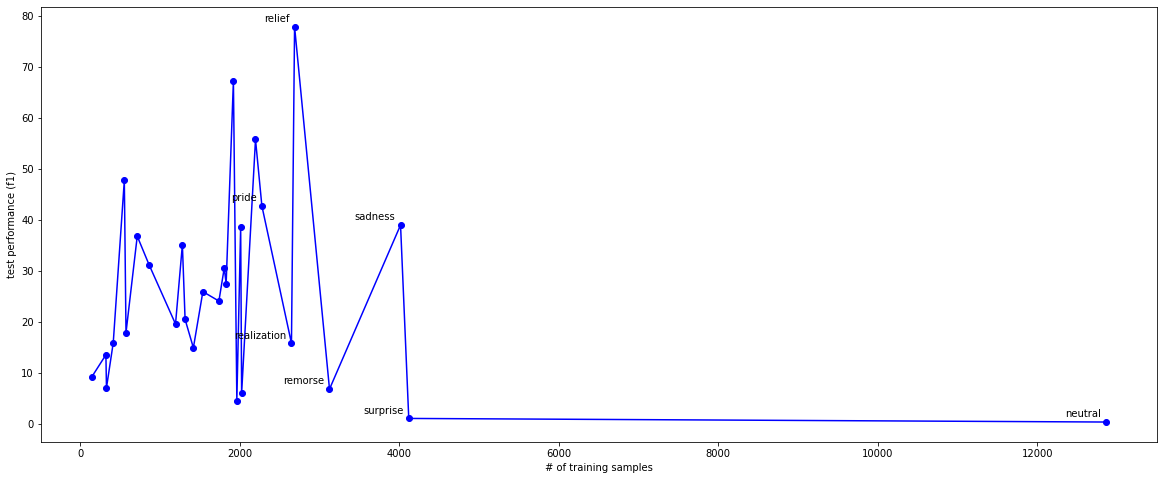

In [109]:
# Plot
n = 7 # num. top classes to label
fig, ax = plt.subplots()
ax.set_xlabel("# of training samples")
ax.set_ylabel("test performance (f1)")
fig.set_size_inches(20, 8)
ax.plot(num_samples, f1s, "bo-")
for x, y, label in zip(num_samples[-n:], f1s[-n:], labels[-n:]):
    ax.annotate(label, xy=(x,y), xytext=(-5, 5), ha="right", textcoords="offset points")

There are, of course, nuances to this general rule such as the complexity of distinguishing between some classes where we may not need as many samples for easier sub-tasks.

## Confusion matrix
Besides just inspecting the metrics for each class, we can also identify the true positives, false positives and false negatives. Each of these will give us insight about our model beyond what the metrics can provide.

- **True positives (TP)**: prediction = ground-truth → learn about where our model performs well.
- **False positives (FP)**: falsely predict sample belongs to class → identify potentially mislabeled samples.
- **False negatives (FN)**: falsely predict sample does not belong to class → identify the model's less performant areas to upsample later.
>It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [110]:
# TP, FP, FN samples
index = labels_dict[tag]
tp, fp, fn = [], [], []
for i in range(len(y_test)):
    true = y_test.values[i][index]
    pred = y_pred[i][index]    
    if true and pred:
        tp.append(i)
    elif not true and pred:
        fp.append(i)
    elif true and not pred:
        fn.append(i)

In [111]:
print(tp)
print(fp)
print(fn)

[29, 33, 83, 117, 159, 201, 308, 318, 440, 448, 489, 498, 538, 599, 648, 660, 703, 766, 772, 815, 857, 872, 882, 909, 952, 956, 1087, 1169, 1191, 1235, 1267, 1307, 1312, 1319, 1439, 1449, 1542, 1561, 1613, 1750, 1756, 1760, 1761, 1790, 1814, 1817, 1837, 1917, 2017, 2083, 2086, 2158, 2270, 2302, 2395, 2425, 2438, 2446, 2484, 2562, 2573, 2592, 2595, 2596, 2663, 2709, 2780, 2823, 2838, 2874, 2953, 2991, 3015, 3037, 3062, 3117, 3122, 3166, 3223, 3269, 3315, 3320, 3341, 3352, 3367, 3478, 3484, 3498, 3506, 3604, 3620, 3652, 3682, 3780, 3808, 3811, 3851, 3905, 3951, 3974, 3987, 4068, 4137, 4138, 4151, 4156, 4274, 4306, 4327, 4361, 4420, 4467, 4475, 4532, 4535, 4542, 4549, 4558, 4718, 4770, 4787, 4854, 4894, 4912, 4925, 5129, 5138, 5167, 5174, 5175, 5215, 5230, 5277, 5352, 5354, 5384, 5425, 5451, 5461, 5523, 5525, 5539, 5609, 5670, 5677, 5697, 5787, 5891, 5906, 5926, 5947, 5959, 5986, 5989, 5994, 5998, 6050, 6089, 6147, 6164, 6183, 6191, 6228, 6248, 6252, 6261, 6277, 6313, 6365, 6426, 6440, 64

In [112]:
index = tp[0]
print (X_test.values[index])
print (f"true: {decode_preds([y_test.values[index]])[0]}")
print (f"pred: {decode_preds([y_pred[index]])[0]}\n")

great, another article from a guy who thought making [name] the head coach was the answer.
true: ['admiration']
pred: ['admiration']



In [113]:
from collections import OrderedDict

# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))

In [114]:
# Samples
num_samples = 3
if len(tp):
    print ("\n=== True positives ===")
    for i in tp[:num_samples]:
        print (f"  {X_test.values[i]}")
        print (f"    true: {decode_preds([y_test.values[i]])[0]}")
        print (f"    pred: {decode_preds([y_pred[i]])[0]}\n")
if len(fp):
    print ("=== False positives === ")
    for i in fp[:num_samples]:
        print (f"  {X_test.values[i]}")
        print (f"    true: {decode_preds([y_test.values[i]])[0]}")
        print (f"    pred: {decode_preds([y_pred[i]])[0]}\n")
if len(fn):
    print ("=== False negatives ===")
    for i in fn[:num_samples]:
        print (f"  {X_test.values[i]}")
        print (f"    true: {decode_preds([y_test.values[i]])[0]}")
        print (f"    pred: {decode_preds([y_pred[i]])[0]}\n")


=== True positives ===
  great, another article from a guy who thought making [name] the head coach was the answer.
    true: ['admiration']
    pred: ['admiration']

  and it tastes great because it was chilling in my refrigerator
    true: ['admiration']
    pred: ['admiration']

  i hear the ruler's control is remote and is viewed with great reception.
    true: ['admiration']
    pred: ['admiration']

=== False positives === 
  summer beaver, nice place. 
    true: ['gratitude']
    pred: ['admiration']

  [name] vs [name] has been a great match... hope [name] can give a fight for the fourth set!
    true: ['gratitude', 'optimism']
    pred: ['admiration', 'optimism']

  that's numberwang!
    true: []
    pred: ['admiration']

=== False negatives ===
  you are a wize man. this was a brilliant conversation
    true: ['admiration']
    pred: []

  its great that she takes care of you, but remember to let her know that she can lean on you
    true: ['admiration']
    pred: []

  i'm

**Tip**

While this view is great for cursory inspection, we should have a scaled version that's tied to labeling and boosting workflows so we can act on our findings from this view.

## Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific probabilities as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

- **Categorical**
 - prediction is incorrect (also indicate TN, FP, FN)
 - confidence score for the correct class is below a threshold
 - confidence score for an incorrect class is above a threshold
 - standard deviation of confidence scores over top N samples is low
 - different predictions from same model using different/previous parameters
- **Continuous**
 - difference between predicted and ground-truth values is above some %

In [115]:
# Confidence score for the incorrect class is above a threshold
high_confidence = []
max_threshold = 0.2
for i in range(len(y_test)):
    indices = np.where(y_test.values[i]==0)[0]
    probs = y_prob[i][indices]
    classes = []
    for index in np.where(probs>=max_threshold)[0]:
        classes.append(labels[indices[index]])
    if len(classes):
        high_confidence.append({"text": test_df.text.values[i], "classes": classes})

In [116]:
high_confidence[0:5]

[{'classes': ['surprise'],
  'text': "considering you are also a child, i can't say i'm surprised by your edgy hot take."},
 {'classes': ['remorse'], 'text': "i'm sorry i watched that"},
 {'classes': ['amusement'],
  'text': "i'm watching it for the first time now. he's perfect for the role lol [name] is a god to me now"},
 {'classes': ['amusement'], 'text': 'let people have fun'},
 {'classes': ['curiosity'],
  'text': 'i grew up in the south and we ate casseroles all the time. so i share your "what?!?!"'}]

## Calibration

But these are fairly crude techniques because neural networks are easily overconfident and so their confidences cannot be used without [calibrating](https://arxiv.org/abs/1706.04599) them.

![](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/evaluation/calibration.png)
> Modern (large) neural networks result in higher accuracies but are over confident.
> [On Calibration of Modern Neural Networks](https://arxiv.org/abs/1706.04599)

- **Assumption**: “the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”
- **Reality**: “modern (large) neural networks are no longer well-calibrated”
- **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling)) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) ([cleanlab](https://github.com/cleanlab/cleanlab)) focuses on identifying noisy labels (with calibration), which can then be properly relabeled and used for training.



In [125]:
import cleanlab
from cleanlab.internal.util import onehot2int
# from cleanlab.pruning import get_noise_indices
from cleanlab.filter import find_label_issues

In [123]:
# Format our noisy labels `s` (cleanlab expects list of integers for multilabel tasks)
correctly_formatted_labels = onehot2int(y_test.values)

In [129]:
# Determine potential labeling errors
# label_error_indices = get_noise_indices(
#             s=correctly_formatted_labels,
#             psx=y_prob,
#             multi_label=True,
#             sorted_index_method="self_confidence",
#             verbose=0)
label_error_indices = find_label_issues(
            labels=correctly_formatted_labels,
            pred_probs=y_prob,
            multi_label=True,
            return_indices_ranked_by="self_confidence",
            verbose=0)

from IPython.display import clear_output 
clear_output()

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predicted outcomes along side results. This way, we can know if we need to relabel, upsample, etc. as mitigation strategies to improve our performance.

In [130]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    print("\ntext:", test_df.iloc[index].text)
    print("labels:", decode_preds([test_df.iloc[index][labels].values]))
    print("pred:", decode_preds([y_pred[index]]))


text: i'm sorry, i can't hear your useless badgering over me drinking my 38' from a wine bottle and enjoying my extra $200.
labels: [['disapproval', 'remorse']]
pred: [['remorse', 'sadness']]

text: i was told that upon waking up from a surgery, my first phrase was “don’t terri [name] me” ☹️
labels: [['realization']]
pred: [['remorse', 'sadness']]

text: i'm sorry but as someone who travels alone i would be pissed if i was told i can't drink at the bar by myself.
labels: [['annoyance', 'remorse']]
pred: [['nervousness', 'remorse', 'sadness']]

text: yep. ~~(also, i'm not interested in getting arrested so sorry.)~~
labels: [['approval']]
pred: [['remorse', 'sadness']]

text: i’m sorry you’re dealing with this too. but hopefully it helps to know you’re not alone...?
labels: [['curiosity', 'optimism']]
pred: [['confusion', 'remorse']]


## Manual slices
Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [131]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [132]:
@slicing_function()
def anger_samples(x):
    """Samples with `anger` label."""
    return x.anger == 1

In [133]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 7  # less than 7 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/v0.9.3/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/v0.9.3/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [134]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text"] + labels].head()

100%|██████████| 10500/10500 [00:00<00:00, 54571.71it/s]


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
29207,when it goes on your keyboard.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
63158,i'm sorry i watched that,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8788,let people have fun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12293,mafia meme...?,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
57286,i love you both,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/v0.9.6/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.



In [135]:
# Slices
slicing_functions = [anger_samples, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
print(slices)

100%|██████████| 10500/10500 [00:00<00:00, 37923.08it/s]


[(0, 0) (0, 0) (0, 0) ... (0, 0) (0, 0) (0, 0)]


If our task was multiclass instead of multilabel, we could've used [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/v0.9.1/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) to retrieve our slice metrics. But we've implemented a naive version for our multilabel task based on it.

In [136]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_true[mask])

In [137]:
print(json.dumps(metrics["slices"], indent=2))

{
  "anger_samples": {
    "precision": 0.34916201117318435,
    "recall": 0.2399232245681382,
    "f1": 0.2844141069397042,
    "num_samples": 369
  },
  "short_text": {
    "precision": 0.37277777777777776,
    "recall": 0.28384094754653133,
    "f1": 0.3222862632084534,
    "num_samples": 2175
  }
}


## Generated slices

Manually creating slices is a massive improvement towards identifying problem subsets in our dataset compared to coarse-grained evaluation but what if there are problematic slices of our dataset that we failed to identify? [SliceLine](https://mboehm7.github.io/resources/sigmod2021b_sliceline.pdf) is a recent work that uses a linear-algebra and pruning based technique to identify large slices (specify minimum slice size) that result in meaningful errors from the forward pass. Without pruning, automatic slice identification becomes computationally intensive because it involves enumerating through many combinations of data points to identify the slices. But with this technique, we can discover hidden underperforming subsets in our dataset that we weren’t explicitly looking for!

![](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/evaluation/slicefinder.png)
>SliceFinder GUI
[Automated Data Slicing for Model Validation](https://arxiv.org/abs/1807.06068)

### Hidden stratification

What if the features to generate slices on are implicit/hidden?

![](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/evaluation/subgroups.png)
> [Distributionally Robust Neural Networks for Group Shifts](https://arxiv.org/abs/1911.08731)

To address this, there are recent [clustering-based techniques](https://arxiv.org/abs/2011.12945) to identify these hidden slices and improve the system.

1. Estimate implicit subclass labels via unsupervised clustering
2. Train new more robust model using these clusters

![](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/evaluation/clustering.png)
>[No Subclass Left Behind: Fine-Grained Robustness in Coarse-Grained Classification Problems](https://arxiv.org/abs/2011.12945)

### Model patching

Another recent work on [model patching](https://arxiv.org/abs/2008.06775) takes this another step further by learning how to transform between subgroups so we can train models on the augmented data:

1. Learn subgroups
2. Learn transformations (ex. [CycleGAN](https://junyanz.github.io/CycleGAN/)) needed to go from one subgroup to another under the same superclass (label)
3. Augment data with artificially introduced subgroup features
4. Train new robust model on augmented data

![](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/evaluation/model_patching.png)
> [Model Patching: Closing the Subgroup Performance Gap with Data Augmentation](https://arxiv.org//2008.06775)

## Explainability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on intuitive features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

**TODO**: Adding relevant code and results for this section this week.

> We can also use model-specific approaches to explainability we we did in our [embeddings lesson](https://madewithml.com/courses/foundations/embeddings/#interpretability), where we used `SAME` padding to extract the most influential n-grams in our text.

## Counterfactuals

Another way to evaluate our systems is to identify counterfactuals -- data with similar features that belongs to another class (classification) or above a certain difference (regression). These points allow us to evaluate model sensitivity to certain features and feature values that may be signs of overfitting. A great tool to identify and probe for counterfactuals (also great for slicing and fairness metrics) is the [What-if tool](https://pair-code.github.io/what-if-tool/).

![](https://4.bp.blogspot.com/-hnqXfHQvl5I/W5b3f-hk0yI/AAAAAAAADUc/hBOXtobPdAUQ5aAG_xOwYf8AWp8YbL-kQCLcBGAs/s640/image2.gif)
> [Identifying counterfactuals using the What-if tool](https://ai.googleblog.com/2018/09/the-what-if-tool-code-free-probing-of.html)

## Behavioral testing

Besides just looking at metrics, we also want to conduct some behavior sanity tests. Behavioral testing is the process of testing input data and expected outputs while treating the model as a black box. They don't necessarily have to be adversarial in nature but more along the types of perturbations we'll see in the real world once our model is deployed. A landmark paper on this topic is [Beyond Accuracy: Behavioral Testing of NLP Models with CheckList](https://arxiv.org/abs/2005.04118) which breaks down behavioral testing into three types of tests:

- `invariance`: Changes should not affect outputs.

In [138]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["loving", "adoring"]
tags = [["admiration"], ["love"]]
texts = [f"I am {token} this." for token in tokens]
print(texts)

['I am loving this.', 'I am adoring this.']


- `directional`: Change should affect outputs.

In [139]:
# DIRectional expectations (changes with known outputs)
tokens = ["loving", "hating"]
tags = [
    ["admiration"], ["love"],
    ["hate"],
]
texts = [f"I am {token} this." for token in tokens]
print(texts)

['I am loving this.', 'I am hating this.']


- `minimum functionality`: Simple combination of inputs and expected outputs.

In [140]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["loving", "hating"]
tags = [["love"], ["hate"]]
# texts = [f"{token} have revolutionized machine learning." for token in tokens]
texts = [f"I am {token} this." for token in tokens]
print(texts)

['I am loving this.', 'I am hating this.']


> We'll learn how to systematically create tests in our [testing lesson](https://madewithml.com/courses/mlops/testing/).

## Evaluating evaluations

How can we know if our models and systems are performing better over time? Unfortunately, depending on how often we retrain or how quickly our dataset grows, it won't always be a simple decision where all metrics/slices are performing better than the previous version. In these scenarios, it's important to know what our main priorities are and where we can have some leighway:

- What criteria are most important?
- What criteria can/cannot regress?
- How much of a regression can be tolerated?


In [142]:
# assert precision > prev_precision  # most important, cannot regress
# assert recall >= best_prev_recall - 0.03  # recall cannot regress > 3%
# assert metrics["class"]["admiration"]["f1"] > prev_data_augmentation_f1  # priority class
# assert metrics["slices"]["class"]["short_text"]["f1"] > prev_cv_transformers_f1  # priority slice

And as we develop these criteria over time, we can systematically enforce them via [CI/CD workflows](https://madewithml.com/courses/mlops/cicd/) to decrease the manual time in between system updates.

Seems straightforward, doesn't it?

With all these different evaluation methods, how can we choose "the best" version of our model if some versions are better for some evaluation criteria?

<details><summary><b> Show answer </b></summary>
<p>

You and your team need to agree on what evaluation criteria are most important and what is the minimum performance required for each one. This will allow us to filter amongst all the different solutions by removing ones that don't satisfy all the minimum requirements and ranking amongst the remaining by which ones perform the best for the highest priority criteria.

</p>
</details>


> In our [testing lesson](https://madewithml.com/courses/mlops/testing/), we'll cover another way to evaluate our model known as [behavioral testing](https://madewithml.com/courses/mlops/testing/#behavioral-testing), which we'll also include as part of performance report.

## Model CI

An effective way to evaluate our systems is to encapsulate them as a collection (suite) and use them for [continuous integration](https://madewithml.com/courses/mlops/cicd/). We would continue to add to our evaluation suites and they would be executed whenever we are experimenting with changes to our system (new models, data, etc.). Often, problematic slices of data identified during [monitoring](https://madewithml.com/courses/mlops/monitoring/) are often added to the evaluation test suite to avoid repeating the same regressions in the future.

## Resources
- [On Calibration of Modern Neural Networks](https://arxiv.org/abs/1706.04599)
- [Confident Learning: Estimating Uncertainty in Dataset Labels](https://arxiv.org/abs/1911.00068)
- [Automated Data Slicing for Model Validation](https://arxiv.org/abs/1807.06068)
- [SliceLine: Fast, Linear-Algebra-based Slice Finding for ML Model Debugging](https://mboehm7.github.io/resources/sigmod2021b_sliceline.pdf)
- [Distributionally Robust Neural Networks for Group Shifts](https://arxiv.org/abs/1911.08731)
- [No Subclass Left Behind: Fine-Grained Robustness in Coarse-Grained Classification Problems](https://arxiv.org/abs/2011.12945)
- [Model Patching: Closing the Subgroup Performance Gap with Data Augmentation](https://arxiv.org//2008.06775)